In [3]:
import pandas as pd
import numpy as np
import os
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

In [112]:
def get_sleep(birthday):
    '''
    This function loads raw .csv data acquired from the 'BabyTracker' app and returns
    a binary time series describing a sleep pattern where '1' corresponds to 'sleep' state and '0' - to 'awake'.

    The output contains the sleep pattern over the last two months where the timestamps are shifted
    such that the infants' birthday is effectively set to 01/01/2000 at 0:00 am.
    The function also returns a timestamp starting from which we will make a prediction.

    :param birthday: baby's birthday which is needed to align this specific timeseries with the average trend
    :return: dataframe containing the last 60 days of sleep data and the timestamp of the latest datapoint
    '''

    data = pd.read_csv('../../data/raw/csv/Alisa_sleep.csv', parse_dates = ['Time'], index_col = 'Time')
    data.columns = ['baby', 'duration', 'note']
    data = data.drop(['baby', 'note'], axis = 1)
    currsleep = 0
    if data.iloc[0, 0] == 0:
        currsleep = 1
        last_nap_start = data.index[0]
    data = data[data.duration >= 15]

    #get the time after which we would like to make a prediction
    modtimesec = os.path.getmtime('../../data/raw/csv/Alisa_sleep.csv')
    finaltime = pd.to_datetime(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(modtimesec)))

    #calculate the number of minutes between the
    finaldelta = (finaltime - data.index[0])/np.timedelta64(1,'m')
    finaltime = finaltime.round(freq = '10min')

    #offset the overall date
    anchordate = pd.to_datetime('01/01/2000')
    subdate = pd.to_datetime(birthday) - anchordate
    data.index -= subdate

    #pick out data over the last 2 months and 5 days
    time_cut = data.index[0] - pd.DateOffset(months = 2, days = 5)
    data = data[data.index > time_cut]

    time_start = data.index[-1]
    data['minutes'] = (data.index - time_start) / np.timedelta64(1,'m')
    data.minutes = data.minutes.apply(int)

    finalminutes = int((finaltime - subdate - time_start) / np.timedelta64(1,'m'))

    #generate a binary timeseries of sleep/awake status with 10-minute steps
    div = 10
    maxt = finalminutes // div
    print(maxt)
    #maxt = data.minutes[0] // div
    data_bin = np.zeros(maxt, dtype=int)
    #print(maxt + int(finaldelta // div))
    interval = 0
    data = data.iloc[::-1]
    datalen = data.shape[0]


    print(maxt)

    for i in range(maxt):
        if data.minutes[interval] <= div * i <= data.minutes[interval] + data.duration[interval]:
            data_bin[i] = 1
        elif div * i > data.minutes[interval] + data.duration[interval]:
            while (interval < datalen-1) and (div * i > data.minutes[interval] + data.duration[interval]):
                interval += 1
    #(interval < datalen) and
    #append last sleep interval
    if currsleep == 1:
        last_sleep_pts = (finaltime - last_nap_start) / np.timedelta64(1,'m')
        last_sleep_pts = int(last_sleep_pts // 10)
        for i in range(last_sleep_pts):
            data_bin[-1 - i] = 1

    dsf = pd.DataFrame(data_bin, dtype = int)
    dsf.columns = ['sleep']
    dsf = dsf[-60 * 144 :]
    dsf.index = pd.date_range(end = (finaltime - subdate).round(freq = '10min'), periods = 60 * 144, freq = '10min')

    trend = pd.read_csv('../../data/NYU_data_processed/NYU_trend.csv', parse_dates = ['timestamps'])
    trend.set_index('timestamps', inplace = True)

    #additional features
    dsf['trend'] = trend.trend
    dsf['time'] = trend.time
    dsf['time_cos'] = trend.time_cos
    dsf['ampm'] = trend.ampm
    
    return dsf, finaltime

In [113]:
birthday = '12/06/2021'
MODEL_PATH = '../models/'

sleep, time0 = get_sleep(birthday)
timeseries = sleep.sleep - sleep.trend
file = open(os.path.join(MODEL_PATH, 'saved_models/SARIMAX_time.txt'), 'r')
last_time = pd.Timestamp(file.read())
timeseries = timeseries[timeseries.index > last_time]

9389
9389


In [96]:
data0.minutes[-1]// 10

0

In [114]:
sleep

,sleep,trend,time,time_cos,ampm
2000-02-16 11:30:00,1,0.363636,11.500000,-0.991445,1
2000-02-16 11:40:00,1,0.378788,11.666667,-0.996195,1
2000-02-16 11:50:00,1,0.401515,11.833333,-0.999048,1
2000-02-16 12:00:00,1,0.416667,12.000000,-1.000000,1
2000-02-16 12:10:00,1,0.409091,12.166667,-0.999048,1
...,...,...,...,...,...
2000-04-16 10:40:00,0,0.265152,10.666667,-0.939693,1
2000-04-16 10:50:00,0,0.280303,10.833333,-0.953717,1
2000-04-16 11:00:00,0,0.280303,11.000000,-0.965926,1
2000-04-16 11:10:00,0,0.265152,11.166667,-0.976296,1


In [ ]:
data

In [62]:
res = SARIMAXResults.load(os.path.join(MODEL_PATH, 'saved_models/SARIMAX.pkl'))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1512
Model:              SARIMAX(10, 0, 0)   Log Likelihood                 -60.707
Date:                Tue, 22 Mar 2022   AIC                            143.414
Time:                        01:09:55   BIC                            201.947
Sample:                    04-05-2000   HQIC                           165.211
                         - 04-16-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8574      0.031     27.414      0.000       0.796       0.919
ar.L2         -0.0155      0.036     -0.434      0.664      -0.085       0.054
ar.L3          0.0137      0.041      0.337      0.736      -0.066       0.093
ar.L4         -0.0090      0.045     -0.198      0.843      -0.098       0.080
ar.L5         -0.0331      0.042     -0.792      0.428      -0.115       0.049
ar.L6          0.0465      0.041      1.125      0.261      -0.035       0.128
ar.L7         -0.0331      0.041     -0.797      0.425      -0.114       0.048
ar.L8          0.0463      0.037      1.265      0.206      -0.025       0.118
ar.L9         -0.0499      0.045     -1.104      0.269      -0.138       0.039
ar.L10        -0.0109      0.032     -0.341      0.733      -0.074       0.052
sigma2         0.0634      0.002     35.073      0.000       0.060       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4836.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.09
Prob(H) (two-sided):                  0.72   Kurtosis:                        11.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
#timeseries = timeseries.asfreq('10min')
res.append(timeseries)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1512
Model:              SARIMAX(10, 0, 0)   Log Likelihood                 -60.707
Date:                Tue, 22 Mar 2022   AIC                            143.414
Time:                        01:05:04   BIC                            201.947
Sample:                    04-05-2000   HQIC                           165.211
                         - 04-16-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8574      0.031     27.414      0.000       0.796       0.919
ar.L2         -0.0155      0.036     -0.434      0.664      -0.085       0.054
ar.L3          0.0137      0.041      0.337      0.736      -0.066       0.093
ar.L4         -0.0090      0.045     -0.198      0.843      -0.098       0.080
ar.L5         -0.0331      0.042     -0.792      0.428      -0.115       0.049
ar.L6          0.0465      0.041      1.125      0.261      -0.035       0.128
ar.L7         -0.0331      0.041     -0.797      0.425      -0.114       0.048
ar.L8          0.0463      0.037      1.265      0.206      -0.025       0.118
ar.L9         -0.0499      0.045     -1.104      0.269      -0.138       0.039
ar.L10        -0.0109      0.032     -0.341      0.733      -0.074       0.052
sigma2         0.0634      0.002     35.073      0.000       0.060       0.067
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4836.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.09
Prob(H) (two-sided):                  0.72   Kurtosis:                        11.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
birthday = '12/06/2021'

DATA_PATH = '../../data/'
data = pd.read_csv(os.path.join(DATA_PATH, 'raw/csv/Alisa_sleep.csv'), parse_dates=['Time'], index_col='Time')
data.columns = ['baby', 'duration', 'note']
data = data.drop(['baby', 'note'], axis=1)

modtimesec = os.path.getmtime('../../data/raw/csv/Alisa_sleep.csv')
finaltime = pd.to_datetime(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(modtimesec)))

currsleep = 0
if data.iloc[0, 0] == 0:
    currsleep = 1
    last_nap_start = data.index[0]

anchordate = pd.to_datetime('01/01/2000')
subdate = pd.to_datetime(birthday) - anchordate
data.index -= subdate





In [24]:
last_sleep_pts

11

In [14]:
data.index[0].round(freq = '10min')

Timestamp('2022-03-21 22:20:00')

In [30]:
DATA_PATH = '../../data/raw/csv/'
modtimesec = os.path.getmtime(os.path.join(DATA_PATH, 'Alisa_sleep.csv'))
modtime = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(modtimesec))
print(modtime)

2022-03-16 17:23:12


In [31]:
DATA_PATH = '../../data/raw/csv/'
data = pd.read_csv(os.path.join(DATA_PATH, 'Alisa_sleep.csv'), parse_dates = ['Time'], index_col = 'Time')
data.columns = ['baby', 'duration', 'note']
data = data.drop(['baby', 'note'], axis = 1)
data = data[data.duration >= 30]
print(data.head())
data.info()

                     duration
Time                         
2022-03-16 14:25:00       135
2022-03-16 07:27:00        73
2022-03-16 02:55:00       100
2022-03-15 21:00:00       335
2022-03-15 13:40:00       140
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 592 entries, 2022-03-16 14:25:00 to 2021-12-07 01:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   duration  592 non-null    int64
dtypes: int64(1)
memory usage: 9.2 KB


In [34]:
birthday = '12/06/2021'
anchordate = pd.to_datetime('01/01/1900')
subdate = pd.to_datetime(birthday) - anchordate
data.index -= subdate

In [35]:
data.head()

,duration
Time,
1900-05-07 14:25:00,135
1900-05-07 07:27:00,73
1900-05-07 02:55:00,100
1900-05-06 21:00:00,335
1900-05-06 13:40:00,140


In [13]:
time0=data.index[-1]
data['minutes'] = (data.index - time0)/np.timedelta64(1,'m')
data.minutes=data.minutes.apply(int)

In [93]:
print(data['minutes'])

Time
2022-01-17 17:15:00    60015
2022-01-17 13:33:00    59793
2022-01-17 08:15:00    59475
2022-01-17 06:05:00    59345
2022-01-17 01:20:00    59060
                       ...  
2021-12-07 19:01:00     1081
2021-12-07 13:00:00      720
2021-12-07 11:40:00      640
2021-12-07 09:30:00      510
2021-12-07 01:00:00        0
Name: minutes, Length: 268, dtype: int64


In [94]:
div=10
maxt=data['minutes'][0]//div
data_bin = np.zeros(maxt, dtype=int)
interval=data.shape[0]-1
for i in range(maxt):
    #print(data.minutes[interval],data.minutes[interval]+data.duration[interval], 5*i)
    if data.minutes[interval] <= div*i <= data.minutes[interval]+data.duration[interval]:
        data_bin[i]=1
    elif div*i > data.minutes[interval]+data.duration[interval]:
        while div*i > data.minutes[interval]+data.duration[interval]:
            interval -=1

In [95]:
ds=pd.Series(data_bin, dtype = int)

In [96]:
dsf = pd.DataFrame(data_bin, dtype = int)

In [97]:
dsf.columns = ['sleep']

<AxesSubplot:>

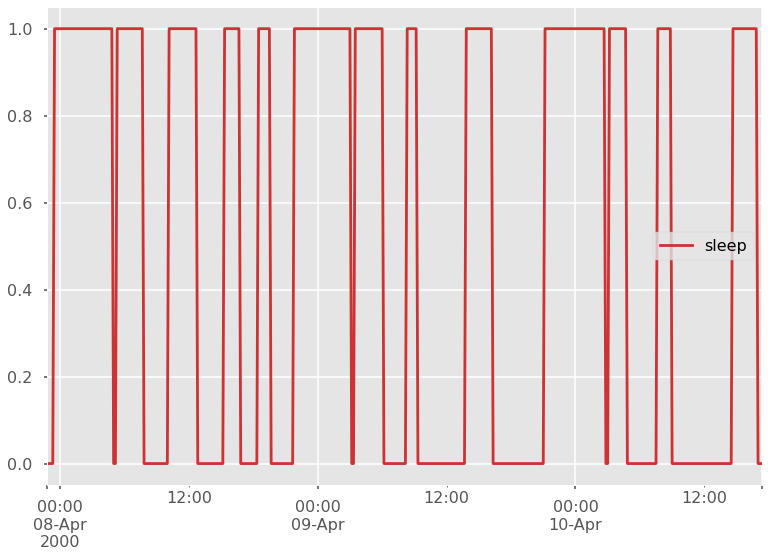

In [145]:
dsf[-400:].plot()

In [99]:
dsf.to_csv("data/sleep_series.csv")

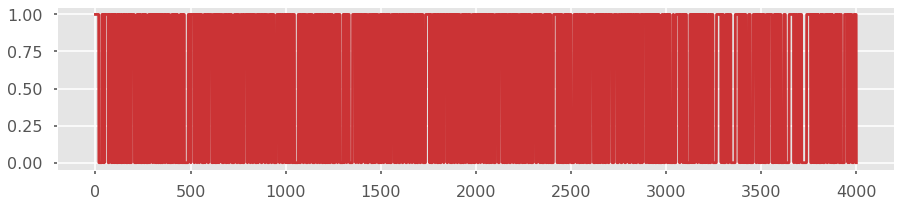

In [89]:
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(111)
ax.plot(data_bin)

In [11]:
data = pd.read_csv(os.path.join(DATA_PATH, 'Alisa_sleep.csv'), parse_dates = ['Time'], index_col = 'Time')
data = data.drop(['Baby', 'Note'], axis = 1)
data = data[data['Duration(minutes)'] >= 30]
print(data.head())
data.info()

                     Duration(minutes)
Time                                  
2022-01-17 17:15:00                 74
2022-01-17 13:33:00                193
2022-01-17 08:15:00                166
2022-01-17 06:05:00                109
2022-01-17 01:20:00                259
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 268 entries, 2022-01-17 17:15:00 to 2021-12-07 01:00:00
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Duration(minutes)  268 non-null    int64
dtypes: int64(1)
memory usage: 4.2 KB


In [12]:
data.head()

,Duration(minutes)
Time,
2022-01-17 17:15:00,74
2022-01-17 13:33:00,193
2022-01-17 08:15:00,166
2022-01-17 06:05:00,109
2022-01-17 01:20:00,259


In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

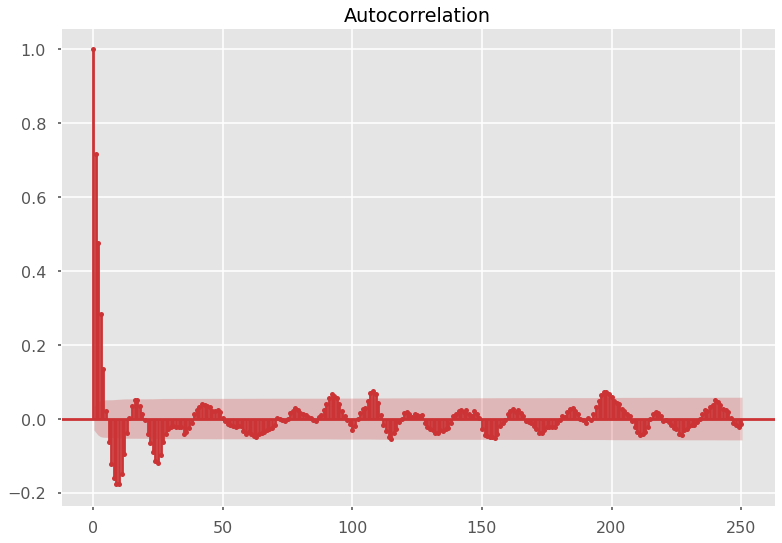

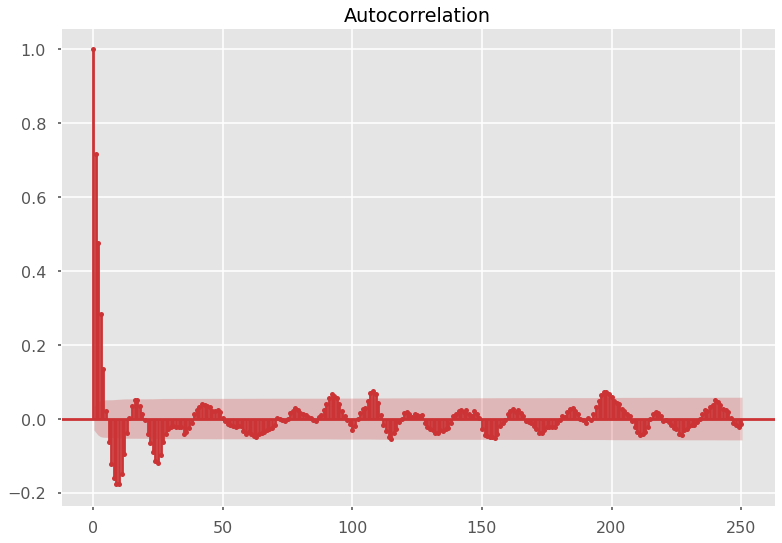

In [14]:
plot_acf(ds, lags = 250, alpha = 0.05)

In [15]:
len(ds.values)

4001

In [44]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

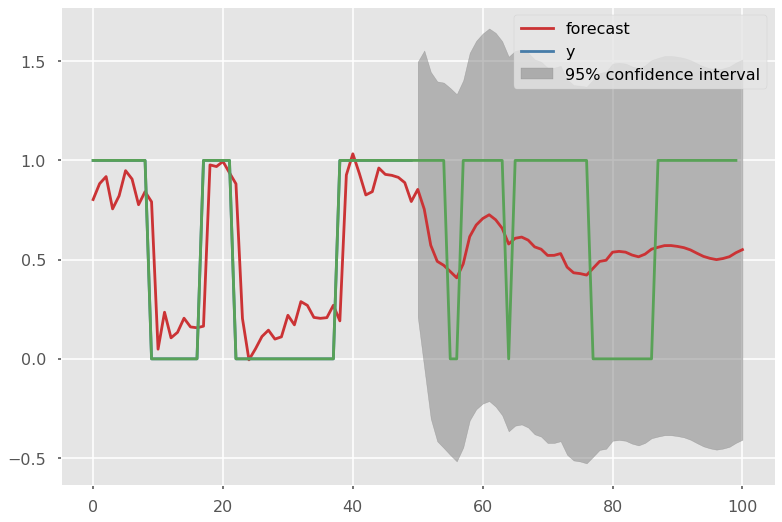

In [49]:
st = 2000
mod = ARIMA(ds.values[st:3950], order=(50,1,2))
res = mod.fit()
res.plot_predict(start=3900-st, end=4000-st)
plot(ds.values[3900:4000])
plt.show()